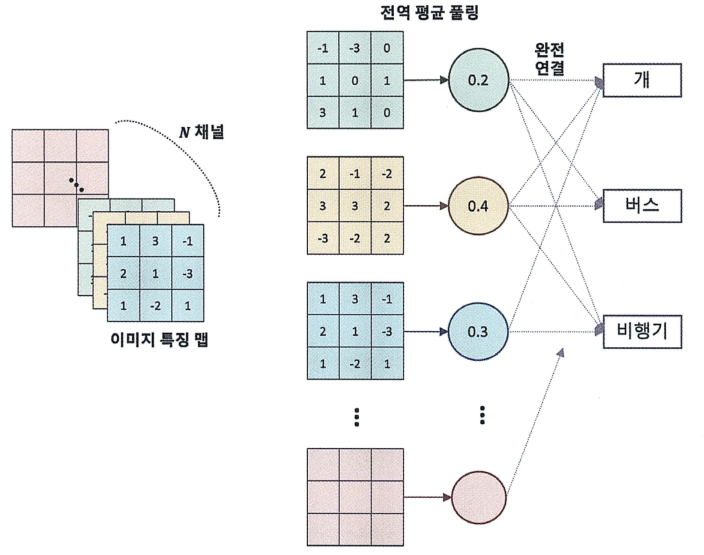

In [ ]:
from torch import nn
from torchvision import models


# - .eval()
#     - 평가 모드로 전환
#         - nn.Module.training = False가 모델과 모든 하위 모듈에 재귀적으로 설정됨.
#     - 적용<br>
#         -Dropout: 비활성화
#         -BatchNorm : 저장된 mean/var 사용
#     - autograd는 끄지 않음: gradient 계산은 가능(따라서, 원하면 학습도 가능)
#         - autograd를 끄려면 torch.no_grad()
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()


# - model.children()
#     - model(nn.Module)의 top-level submodules을 등록 순서대로 내주는 iterator
#         - iterator: 데이터의 원소들을 차례대로 접근할 수 있는 객체
# - list(model.children())
#     - slicing 을 위해 iterator를 list로 변환
#     - [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc]
# - * (언패킹 연산자)
#     리스트 통째로 넘기지 않고, 리스트를 풀어서 내부 인자들을(여기서는 모듈들) 개별 인자로 넘김
#     즉, 결과적으로
#     nn.Sequential([m1, m2, ..., mk]) 가 아니라
#     nn.Sequential(m1, m2, ..., mk)   형태가 됨.
#
# - nn.Sequential(...)
#     전달받은 모듈들을 앞에서 뒤 순서로 차례차례 실행하는 새 모듈을 만듦.
# 결과: features = “마지막 두 층을 뺀 나머지를 직렬로 묶은 특징 추출기”
features = nn.Sequential(*list(model.children())[:-2])

## (참고)
# - print(model.children)을 하면 top-level submodules를 포함한 더 깊은 내부까지 출력되는 이유
#   - print(class_obj)를 하면 내부적으로 obj.__str__()과 __repr__()를 우선순위 순서대로 찾는데, 둘다 없으면 obj 주소를 출력
#   - nn.Module에는 __repr__()가 재정의 되어 있어, repr(obj)를 호출함.
#   - 재정의된 내용은 "module tree"를 재귀적으로 예쁘게 출력 하도록 하는 내용임

In [3]:
print(model.children)

<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),

        # PIL,ndarray,0~255 image를 torch.float32,0~1 Tensor로 변환
        # HWC -> CHW
        transforms.ToTensor(),

        # 채널별로 x=(x-mean)/std 적용
        transforms.Normalize(
            # ImageNet 학습 분포의 평균/표준편차(각 채널 RGB)
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("./datasets/images/airplane.jpg")
# print(image.size)         #(320,175) PIL_image.size는 W,H 순서로 출력<br>
# arr = np.asarray(img)<br>
# print(arr.shape)          #(175,320,3) PIL_image 내부 구조는 H,W,C<br>

target = transform(image).unsqueeze(0)
# transform(image).shape        #torch.Size([3, 224, 224])<br>
# transform(image).unsqueeze(0) #torch.Size([1, 3, 224, 224])<br>

output = model(target) #output.shape = [1,1000]
class_idx = int(output.argmax()) #404

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
#model.fc.weight[class_idx].shape #512 (class_idx와 연결된 FCN 의 수(feature의 수))
#reshape(-1) : 해당 차원의 크기를 자동으로 계산

features_output = features(target).squeeze()
#features(target).shape=torch.Size(1,512,7,7])

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [ ]:
import torch
from torch.nn import functional as F


cam = features_output * weights #[512,7,7] * [512,1,1], 자동으로 shape을 맞춘후 elements wise 수행, 각각의 [7,7]행렬에 스칼라 값을 곱
cam = torch.sum(cam, dim=0) #[7,7] 0번 축을 따라서 합을 구하고, 결과적으로 0번 축을 없앤다.


# 7x7 cam(heat map) 을 원본 이미지 크기로 늘려준다.
# - input=cam.unsqueeze(0).unsqueeze(0)
#     - F.interpolate 의 입력은 4D(N,C,H,W) 이므로 차원을 맞춤
# - size=(image.size[1], image.size[0])
#     - 원본 이미지 해상도
#     - PIL_image.size = (W,H)
#     - interploate out size = (H,W)
# - mode="bilinear"
#     - bilinear 방상으로 보간
# - .squeeze()
#     - [1,1,H,W] -> [H,W]
# - .detach()
#     - Forward에서 만들어진 autograd computation graph에서 분리
#     - .clone().detach()가 안전하긴 함.
# - .numpy()
#     -numpy로 변환
#     -GPU Tensor라면 .cpu().numpy()가 되어야 함. (numpy는 cpu에서 동작하므로)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

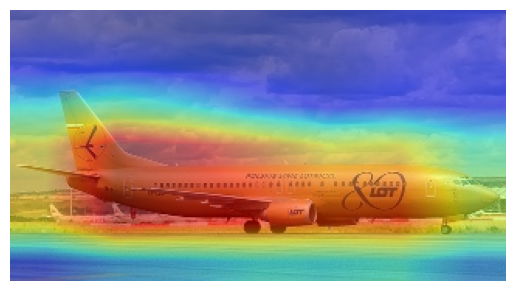

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(image)

# imshow()는 입력 이미지가 0~255 범위가 아니더라도 자동으로 최소~최대를 선형 스케일링 함
# cmap='jet'은 2D gray scale 을 3D color image로 보이게 함
# alpha=0.5 투명도 50%로 곂칩
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()